# Variational Classification

In this section, we introduce variational algorithms, then describe and implement variational quantum classifier.  

## Contents

1. [Variational Algorithms](#Variational-Algorithms)
1. [Variational Quantum Classifier](Variational-Quantum-Classifier)
    1. [Full Implementation](#Full-Implementation)
    2. [Qiskit Implementation](#Qiskit-Implementation)
1. [References](#References)

## Variational Algorithms

Variational algorithms were introduced in 2014, with the variational eigensolver in Reference [1](#References) and the quantum approximate optimization algorithm in Reference [2](#References). They are near-term algorithms, that can be executed on current quantum computers in concert with classical computers. 

Using a parameterised quantum circuit $U(\theta)$, we prepare a state $\psi(\theta) \rangle = U(\theta) |0 \rangle$, and measure the expectation value using a quantum computer. We define a cost function $C(\theta)$, that determines how good $\theta$ is for the problem we are trying to solve. We use a classical computer to calculate the cost function and provide updated circuit parameters using an optimization algorithm. The goal of the algorithm is to find the circuit parameters $\theta$ for the parameterised quantum circuit $U(\theta)$ that minimizes the cost function $C(\theta)$. 

<figure>
  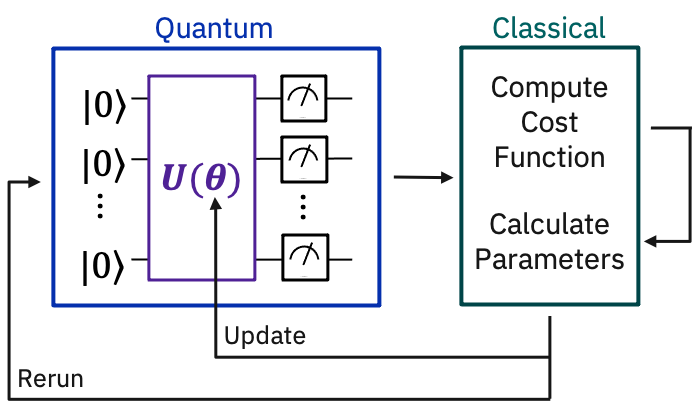
</figure> 


## Variational Quantum Classifier

The variational quantum classifier is a variational algorithm where the measured expectation value is interpreted as the output of a classifier, introduced by mutiple groups in 2018. For a binary classification problem, with input data vectors $\vec{x}_i$ and binary output labels $y_i = \{0,1\}$; for each input data vector, we build a parameterised quantum circuit whose outputs is the quantum state: 
$$ |\psi(\vec{x}_i;\vec{\theta}) \rangle =  U_{W(\vec{\theta})}U_{\phi(\vec{x}_i)}|0 \rangle$$
where $U_{W(\vec{\theta})}$ corresponds to the variational circuit unitary and $U_{\phi(\vec{x}_i)}$ corresponds to the data encoding circuit unitary. After creating and measuring the circuit of $n$ qubits, we are left with a $n$ length bitstring from which we must derive a binary output which will be our classification result. This is done with the help of a boolean function $f: \{0, 1\}^{n} \rightarrow \{0, 1\}$.

<figure>
  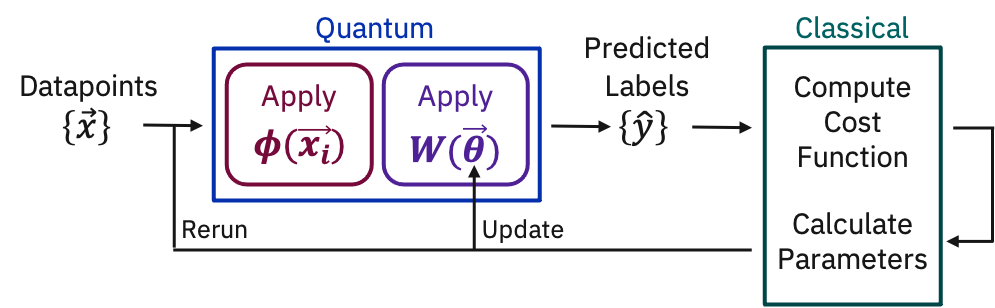
</figure>

In the training phase, we are trying to find the values for $\vec{\theta}$ that give us the best predictions. The classical computer compares the predicted labels $\hat{y_i}$, to the provided labels $y_i$, and we calculate the success of our predictions using a cost function. Based on this cost, the classical computer chooses another value for $\vec{\theta}$ using a classical optimization algorithm. This new $\vec{\theta}$ is then used to run a new circuit, and the process is repeated until the cost function stabilizes.

### Full Implementation

Let's implement all the separate components of the variational quantum classifer, and classify the `adhoc` dataset, as described in Reference [3](#References), following the [implementation](https://github.com/0x6f736f646f/variational-quantum-classifier-on-heartattack/blob/main/Src/Notebooks/02-qiskit.ipynb) from [Rodney Osodo](https://medium.com/qiskit/building-a-quantum-variational-classifier-using-real-world-data-809c59eb17c2).

1. We create 20 training datapoints and 5 testing datapoints of 2 features from each class.

In [1]:
from qiskit.utils import algorithm_globals
algorithm_globals.random_seed = 12345

from qiskit_machine_learning.datasets import ad_hoc_data

train_data, train_labels, test_data, test_labels= \
    ad_hoc_data(training_size=20, test_size=5, n=2, gap=0.3, one_hot=False)

2. We prepare the classification circuit, using the Qiskit `ZZFeatureMap` as the data encoding circuit, and the Qiskit `TwoLocal` circuit with $Y$ and $Z$ rotations and controlled-phrase gates, as the variational circuit, as per Reference [3](#References).

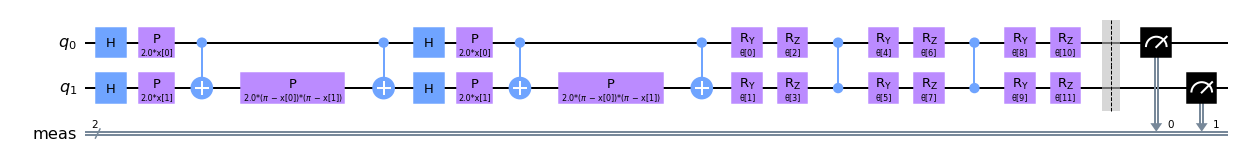

In [2]:
from qiskit.circuit.library import ZZFeatureMap, TwoLocal

adhoc_feature_map = ZZFeatureMap(feature_dimension=2, reps=2)
adhoc_var_form = TwoLocal(2, ['ry', 'rz'], 'cz', reps=2)

adhoc_circuit = adhoc_feature_map.compose(adhoc_var_form)
adhoc_circuit.measure_all()
adhoc_circuit.draw(output="mpl")

3. We create a function that associates the data to the feature map and the variational parameters to the variational circuit. This is to ensure that the right parameters in the circuit are associated with the right quantities.

In [3]:
def circuit_parameters(data, variational):
    parameters = {}
    for i, p in enumerate(adhoc_feature_map.ordered_parameters):
        parameters[p] = data[i]
    for i, p in enumerate(adhoc_var_form.ordered_parameters):
        parameters[p] = variational[i]
    return parameters

4. We create a class assignment function to calculate the parity of the given bitstring. If the parity is even, it returns a $1$ label, and if the parity is odd it returns a $0$ label, as per Reference [3](#References).

In [4]:
def assign_label(bitstring):
    hamming_weight = sum([int(k) for k in list(bitstring)])
    odd = hamming_weight & 1
    if odd:
        return 0
    else:
        return 1

5. We create a function the returns the probability distribution over the label classes, given experimental counts from running the quantum circuit multiple times.

In [5]:
def label_probability(results):
    shots = sum(results.values())
    probabilities = {0: 0, 1: 0}
    for bitstring, counts in results.items():
        label = assign_label(bitstring)
        probabilities[label] += counts / shots
    return probabilities

6. We create a function that classifies our data. It takes in data and parameters. For every data point in the dataset, we assign the parameters to the feature map and the parameters to the variational circuit. We then evolve our system and store the quantum circuit, so as to run the circuits at once at the end. We measure each circuit and return the probabilities based on the bit string and class labels.

In [6]:
from qiskit import BasicAer, execute

def classification_probability(data, variational):
    circuits = [adhoc_circuit.assign_parameters(circuit_parameters(d,variational)) for d in data]
    backend = BasicAer.get_backend('qasm_simulator')
    results =  execute(circuits, backend).result()

    classification = [label_probability(results.get_counts(c)) for c in circuits]
    return classification

7. For training, we create the loss and cost functions.

In [7]:
import numpy as np

def cross_entropy_loss(predictions, expected):
    p = predictions.get(expected)
    return -(expected*np.log(p)+(1-expected)*np.log(1-p))
   
def cost_function(data, labels, variational):
    classifications = classification_probability(data, variational)
    
    cost = 0
    for i, classification in enumerate(classifications):
        cost += cross_entropy_loss(classification, labels[i])
    cost /= len(data)

    return cost

8. We set up our classical optimizer, using [`SPSA`](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.SPSA.html) as per Reference [3](#References), initialize our variational circuit parameters randomly, and optimize our cost function modifying the variational circuit parameters, using our 40 training datapoints. Note that this will take a while to run. 

In [8]:
from qiskit.algorithms.optimizers import SPSA

# Callback function for optimiser for plotting purposes
parameters = []
costs = []
evaluations = []
def store_intermediate_result(evaluation, parameter, cost, stepsize, accept):
    evaluations.append(evaluation)
    parameters.append(parameter)
    costs.append(cost)

optimizer = SPSA(maxiter=100, callback=store_intermediate_result)

# Set initial variational parameters
np.random.seed(algorithm_globals.random_seed)
init_var = 2*np.pi*np.random.rand(adhoc_var_form.num_parameters)

objective_function = lambda variational: cost_function(train_data, train_labels, variational)

opt_var, opt_value, _ = optimizer.optimize(len(init_var), objective_function, initial_point=init_var)

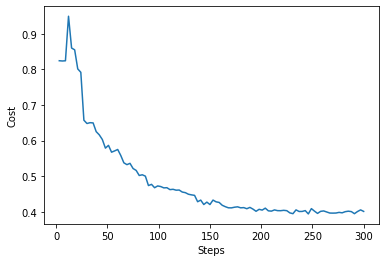

In [9]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(evaluations, costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

9. We implement a function to score our variational quantum classifier, using the classification function we created earlier, and use it to test our trained classifer on our 10 test datapoints. 

In [10]:
def score_classifier(data, labels, variational):
    probability = classification_probability(data, variational)

    accuracy = 0
    for i, p in enumerate(probability):
        if (p[0] >= p[1]) and (labels[i] == 0):
            accuracy += 1
        elif (p[1]) >= p[0] and (labels[i] == 1):
            accuracy += 1
    accuracy /= len(labels)
    return accuracy

In [11]:
score_classifier(test_data, test_labels, opt_var)

0.4

### Qiskit Implementation

Qiskit has an implementation of the variational quantum classifer in the [`VQC`](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.algorithms.VQC.html) class. Let's use it on the same dataset. 

First, we need to one hot encode our labels, as required by the algorithm.

In [12]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
train_labels_oh = encoder.fit_transform(train_labels.reshape(-1, 1)).toarray()
test_labels_oh = encoder.fit_transform(test_labels.reshape(-1, 1)).toarray()

Second, we set up the `VQC` and fit to our training data.

In [13]:
from qiskit_machine_learning.algorithms.classifiers import VQC

parameters = []
costs = []
evaluations = []

vqc = VQC(feature_map=adhoc_feature_map,
          ansatz=adhoc_var_form,
          loss='cross_entropy',
          optimizer=SPSA(callback=store_intermediate_result),
          quantum_instance=BasicAer.get_backend('qasm_simulator'))

vqc.fit(train_data, train_labels_oh)

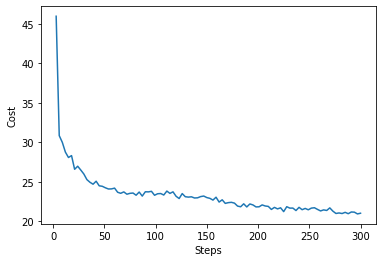

In [14]:
fig = plt.figure()
plt.plot(evaluations, costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

Third, we test the trained classifier on the test data. 

In [15]:
vqc.score(test_data, test_labels_oh)

0.6

_TODO_ interactive widget and conclusion

## References

1. Alberto Peruzzo, Jarrod McClean, Peter Shadbolt, Man-Hong Yung, Xiao-Qi Zhou, Peter J. Love, Alán Aspuru-Guzik and Jeremy L. O'Brien, *A variational eigenvalue solver on a quantum processor*, Nature Communications, 5:4213 (2014), [doi.org:10.1038/ncomms5213](https://doi.org/10.1038/ncomms5213), [arXiv:1304.3061](https://arxiv.org/abs/1304.3061).
1. Edward Farhi, Jeffrey Goldstone and Sam Gutmann, *A Quantum Approximate Optimization Algorithm* (2014), [arXiv:1411.4028](https://arxiv.org/abs/1411.4028).
1. Vojtech Havlicek, Antonio D. Córcoles, Kristan Temme, Aram W. Harrow, Abhinav  Kandala, Jerry M. Chow and Jay M. Gambetta, *Supervised learning with quantum enhanced feature spaces*, Nature 567, 209-212 (2019), [doi.org:10.1038/s41586-019-0980-2](https://doi.org/10.1038/s41586-019-0980-2), [arXiv:1803.07128](https://arxiv.org/abs/1803.07128).

In [16]:
import qiskit.tools.jupyter
%qiskit_version_table